In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [ ]:
!pip show gluonts

In [4]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

In [6]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [15]:
from gluonts.evaluation import make_evaluation_predictions

In [7]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [8]:
dataset = get_dataset("m4_hourly")

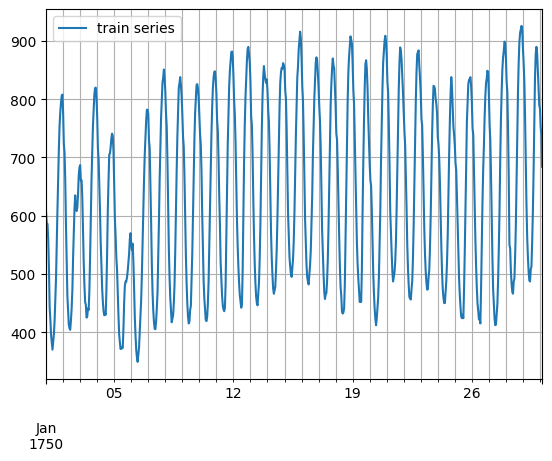

In [9]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [10]:
train_series.head()

1750-01-01 00:00    605.0
1750-01-01 01:00    586.0
1750-01-01 02:00    586.0
1750-01-01 03:00    559.0
1750-01-01 04:00    511.0
Freq: H, dtype: float32

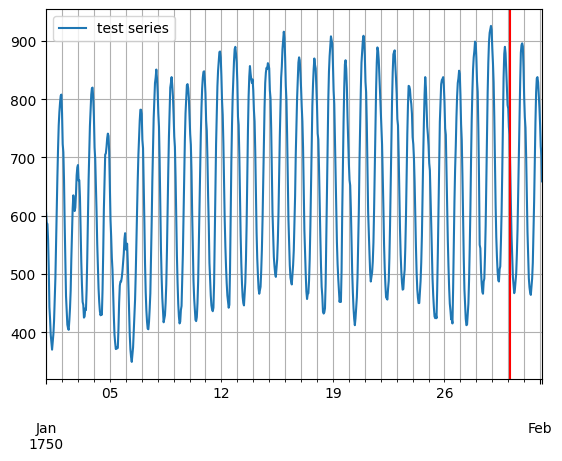

In [11]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which = "both")
plt.legend(["test series"], loc = "upper left")
plt.show()

In [12]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


#### custom dataset

In [40]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

In [43]:
custom_dataset.shape

(10, 100)

In [41]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

In [13]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [14]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:01<00:00, 92.85it/s, epoch=5/5, avg_epoch_loss=4.58]


In [16]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [17]:
forecasts = list(forecast_it)
tss = list(ts_it)

#### Examine the time series values

In [18]:
# first entry of the time series list
ts_entry = tss[0]

# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [19]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

# first 5 values
dataset_test_entry["target"][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

#### Examine the predicted values

In [20]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [21]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


In [22]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [733.5418  543.08453 501.45197 520.4771  509.36636 454.0546  504.46133
 416.61536 534.0896  480.88226 652.0254  705.2851  719.35065 783.38763
 881.3398  851.35126 754.80396 879.8908  789.95276 779.0887  780.53485
 667.2338  741.2137  704.24194 584.1127  576.3171  549.7456  505.90106
 507.59525 400.57312 501.69067 462.1694  442.81097 487.5898  606.57477
 685.44586 798.0008  911.5057  934.4579  810.61835 902.938   756.7477
 990.1718  752.4896  723.1548  785.69366 703.7023  613.3522 ]
0.5-quantile (median) of the future window:
 [725.88904 550.7123  492.02704 519.9595  496.64496 465.9499  498.42422
 439.35986 537.9283  486.0233  591.6514  696.41016 733.6381  791.3633
 889.8253  860.59143 784.3906  911.17    784.55084 781.5133  778.13416
 669.5068  734.2073  682.73096 584.2881  578.1526  550.46893 494.8831
 513.8469  396.90543 515.9859  464.50812 450.55286 474.48773 611.6906
 674.52655 796.8036  905.07697 938.0467  804.6431  936.96466 775.50104
 956.1224  749.54

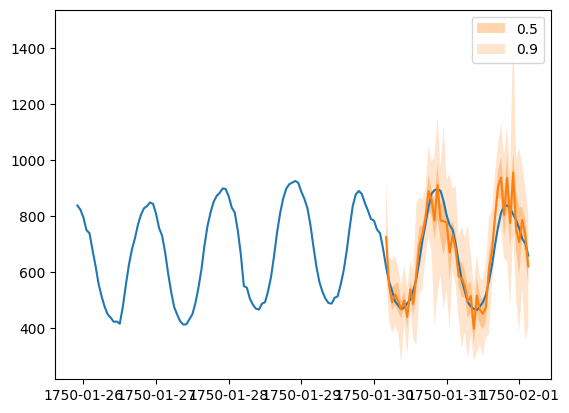

In [23]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [24]:
from gluonts.evaluation import Evaluator

In [25]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 414it [00:00, 2164.75it/s]


In [26]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 11789979.621239126,
    "abs_error": 10726290.499477386,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 5.230398793531103,
    "MAPE": 0.2621096819639206,
    "sMAPE": 0.2048042700798423,
    "MSIS": 65.4570029179563,
    "QuantileLoss[0.1]": 6221395.227100468,
    "Coverage[0.1]": 0.10532407407407406,
    "QuantileLoss[0.5]": 10726290.501289368,
    "Coverage[0.5]": 0.43332326892109496,
    "QuantileLoss[0.9]": 6414605.266247653,
    "Coverage[0.9]": 0.8655897745571659,
    "RMSE": 3433.653975175589,
    "NRMSE": 0.46876961050190835,
    "ND": 0.07369039737066325,
    "wQuantileLoss[0.1]": 0.04274143857164026,
    "wQuantileLoss[0.5]": 0.0736903973831117,
    "wQuantileLoss[0.9]": 0.044068805620057536,
    "mean_absolute_QuantileLoss": 7787430.33154583,
    "mean_wQuantileLoss": 0.05350021385826983,
    "MAE_Coverage": 0.3885299248523886,
    "OWA": NaN
}


In [27]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,1750-01-30 04:00,4278.196615,2370.529297,31644.0,659.250000,42.371302,1.165554,0.073254,0.072559,0.074912,12.887803,1329.999658,0.062500,2370.529053,0.520833,1236.242871,1.000000
1,1,1750-01-30 04:00,138183.375000,15771.987305,124149.0,2586.437500,165.107988,1.990110,0.131922,0.121624,0.127041,14.131909,5119.257080,0.208333,15771.987061,0.854167,7843.317920,1.000000
2,2,1750-01-30 04:00,55680.796875,7917.807129,65030.0,1354.791667,78.889053,2.090966,0.108568,0.119164,0.121756,14.854171,4006.870129,0.000000,7917.807129,0.166667,3431.579907,0.645833
3,3,1750-01-30 04:00,321634.458333,19973.992188,235783.0,4912.145833,258.982249,1.606770,0.080966,0.084172,0.084713,14.820700,11062.092236,0.000000,19973.992676,0.312500,7560.735449,0.916667
4,4,1750-01-30 04:00,80700.979167,9837.814453,131088.0,2731.000000,200.494083,1.022247,0.078019,0.075719,0.075047,12.952202,5800.298706,0.062500,9837.814209,0.583333,6366.430664,1.000000


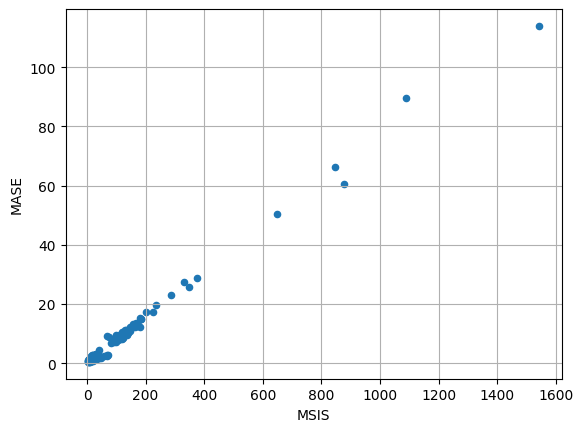

In [28]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

#### Custom dataset

In [30]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq)  # can be different for each time series

In [34]:
from gluonts.dataset.common import ListDataset

In [35]:
custom_dataset.shape

(10, 100)

In [36]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

In [39]:
train_ds

[{'target': array([-1.5593663 , -1.2204363 ,  0.17803378,  0.2573434 ,  0.47739145,
          0.3308067 ,  1.3146359 , -1.2161939 ,  1.4429455 , -0.42965406,
          0.9288848 ,  0.83709794,  0.14801668,  0.3998001 ,  0.16911918,
          0.5264576 , -0.5728293 , -0.3545338 ,  0.29224572, -1.0879525 ,
          0.12937614, -0.22163436,  2.328334  , -1.313642  , -1.4656333 ,
          0.0353682 , -0.538867  , -0.27557558,  0.8134563 ,  0.7283025 ,
          0.34057924, -0.19558689,  0.97147834,  0.956863  ,  0.03769438,
         -0.97474176, -0.19894858, -2.0101824 ,  1.5407987 ,  0.90338296,
         -0.0958663 , -0.6009115 , -0.08163657,  1.9810759 , -0.4537213 ,
         -0.30427858,  1.6843048 , -0.13106313,  1.4075857 , -0.1023403 ,
         -0.5426109 ,  0.1602811 , -2.2307484 ,  0.50214165,  0.0313601 ,
         -1.1338826 ,  0.7170878 , -0.660986  , -0.22101218,  0.67115504,
         -0.00279234, -0.93478847, -1.2784313 , -0.51660454, -1.3440988 ,
          1.385961  , -0.166